In [2]:
# Imports
import pykep as pk
from pykep.orbit_plots import plot_planet, plot_lambert
from pykep import AU, DAY2SEC
import pygmo as pg
import numpy as np

# Plotting imports
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [27]:
# We define the Lambert problem
t1 = pk.epoch_from_string('2035-01-01 23:59:54.003')
t2 = pk.epoch_from_string('2036-12-20 23:59:54.003')
dt = (t2.jd - t1.jd) * DAY2SEC

earth = pk.planet.jpl_lp('earth')
rE, vE = earth.eph(t1)

mars = pk.planet.jpl_lp('mars')
rM, vM = mars.eph(t2)

# We solve the Lambert problem
l = pk.lambert_problem(r1 = rE, r2 = rM, tof = dt, mu = pk.MU_SUN, max_revs=2)

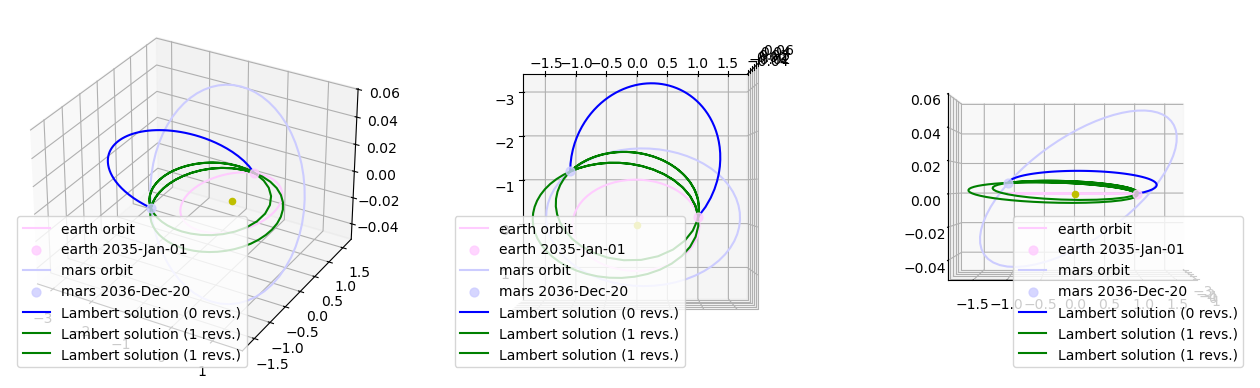

In [31]:
# We plot
mpl.rcParams['legend.fontsize'] = 10

# Create the figure and axis
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter([0], [0], [0], color=['y'])

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter([0], [0], [0], color=['y'])
ax2.view_init(90, 0)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter([0], [0], [0], color=['y'])
ax3.view_init(0,0)

for ax in [ax1, ax2, ax3]:
    # Plot the planet orbits
    plot_planet(earth, t0=t1, color=(1, 0.8, 1), legend=True, units=AU, axes=ax)
    plot_planet(mars, t0=t2, color=(0.8, 0.8, 1), legend=True, units=AU, axes=ax)
    # Plot the Lambert solutions
    axis = plot_lambert(l, color='b', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=1, color='g', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=2, color='g', legend=True, units=AU, axes=ax)